# Graph tutorial

In this tutorial we introduce the notion of `MultiModalGraph`, how to construct it, manipulate it.

`MultiModalGraph` is made of two component, the `flow_graph` and the `mobility_graph`. They both are an `OrientedGraph`, but one is geometric and the other topologic. 
The `flow_graph` is a geometric representation of the roads. The `mobility_graph` represent each mobility service define on the `flow_graph`.

## Create a simple flow graph

### Instanciation

In [1]:
import mnms as ms

mmgraph  = ms.MultiModalGraph()
flow_graph = mmgraph.flow_graph

### Adding nodes

In [2]:
flow_graph.add_node('0', [0, 0])
flow_graph.add_node('1', [1, 0])
flow_graph.add_node('2', [1, 1])
flow_graph.add_node('3', [0, 1])

flow_graph.nodes

{'0': GeoNode(id=0, pos=[0 0]),
 '1': GeoNode(id=1, pos=[1 0]),
 '2': GeoNode(id=2, pos=[1 1]),
 '3': GeoNode(id=3, pos=[0 1])}

### Adding links

In [3]:
flow_graph.add_link('0_1', '0', '1')
flow_graph.add_link('1_2', '1', '2')
flow_graph.add_link('2_3', '2', '3')
flow_graph.add_link('3_0', '3', '0')

flow_graph.links

{('0', '1'): GeoLink(id=0_1, upstream=0, downstream=1, len=1.0),
 ('1', '2'): GeoLink(id=1_2, upstream=1, downstream=2, len=1.0),
 ('2', '3'): GeoLink(id=2_3, upstream=2, downstream=3, len=1.0),
 ('3', '0'): GeoLink(id=3_0, upstream=3, downstream=0, len=1.0)}

### Rendering

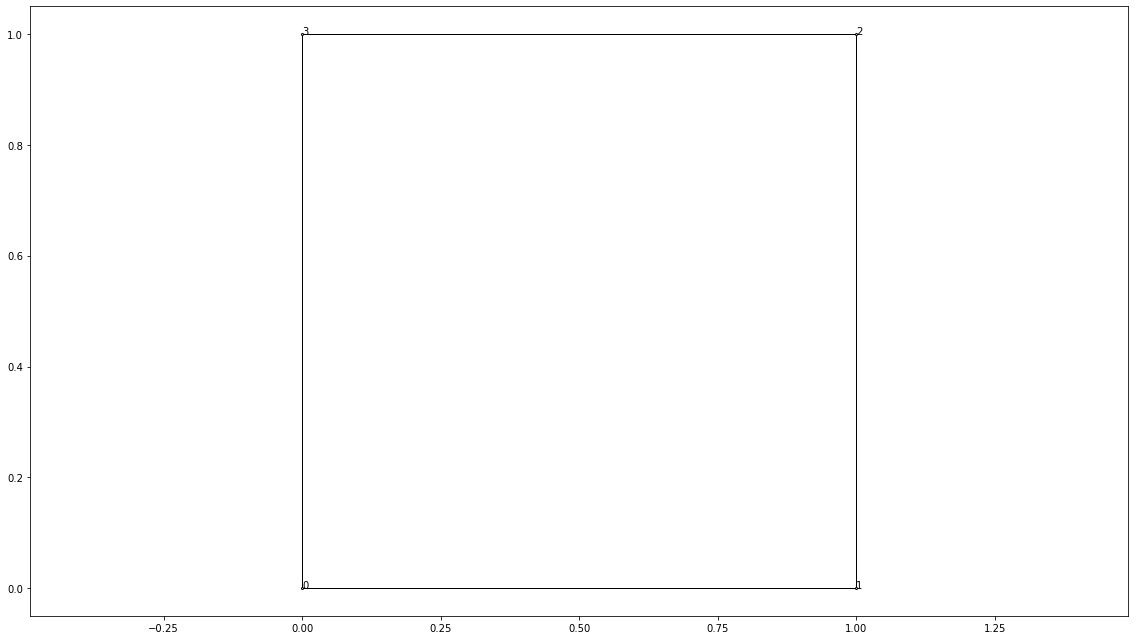

In [4]:
from mnms.tools.render import draw_flow_graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
draw_flow_graph(ax, flow_graph)